In [6]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import numpy as np
import collections
import pandas as pd
import math

import matplotlib.pyplot as plt

import pickle
import glob
import re
import os

from tqdm import tqdm
from scipy.optimize import curve_fit

In [3]:
#*****INITIALIZE GPU****#
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-09 12:36:47.639431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 12:36:48.054980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 12:36:48.055256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
#******CUSTOM LEARNING RATE******#
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate, epochs, steps_per_epoch):
    self.initial_learning_rate = initial_learning_rate
    self.epochs = epochs
    self.steps_per_epoch = steps_per_epoch
    self.m = initial_learning_rate / steps_per_epoch
    self.decay_rate = tf.constant((10**-8 / initial_learning_rate)**(((epochs - 1)*steps_per_epoch)**-1), dtype=tf.float32)
    print('decay_rate:', self.decay_rate)

  def __call__(self, step):
    result = tf.cond(tf.less(step, self.steps_per_epoch), 
                   lambda: self.m * (step+1),
                   lambda: self.initial_learning_rate * self.decay_rate**tf.cast(step+1-self.steps_per_epoch, dtype=tf.float32))

    #tf.print('lr at step', step, 'is', result, output_stream='file://learning_rates.txt')
    return result  

  def get_config(self):
      return {
          "initial_learning_rate": self.initial_learning_rate,
          "epochs": self.epochs,
          "steps_per_epoch": self.steps_per_epoch
      }

In [19]:
lr = MyLRSchedule(initial_learning_rate=1e-3, epochs=15, steps_per_epoch=math.ceil(5000*1002/64))

decay_rate: tf.Tensor(0.9999895, shape=(), dtype=float32)


In [20]:
steps = np.arange(0,math.ceil(5000*1002/64)*15)
y = np.array([lr(s) for s in steps])

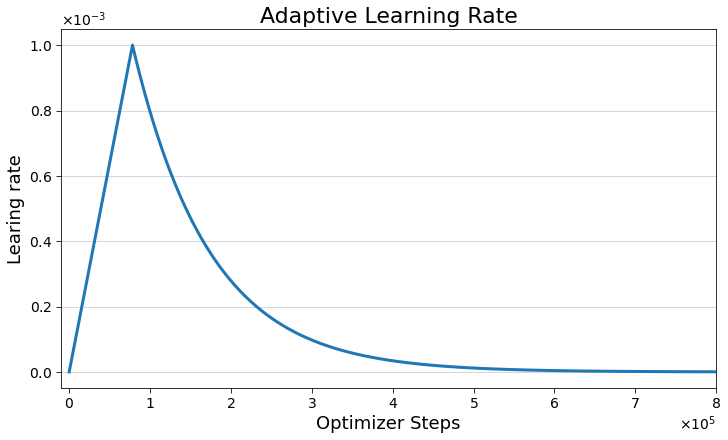

In [47]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,6),constrained_layout = True)

ax.plot(steps, y, lw=3)
ax.set_title("Adaptive Learning Rate",fontsize=22)
ax.set_xlabel("Optimizer Steps",fontsize=18)
ax.set_ylabel("Learing rate",fontsize=18)
ax.set_xlim(left=-1e4,right=0.8*1e6)
ax.grid(axis="y", color="k", alpha=0.2)

# ax.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.0e'))

ax.tick_params(axis="both", which="major", labelsize=14, length=5)
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(14)
ax.ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0, 0))
ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.xaxis.get_offset_text().set_fontsize(14)
ax.ticklabel_format(axis = 'x', style = 'scientific', scilimits = (0, 0))

fig.savefig("../images/Lr.png", dpi=300, facecolor="white")